<a href="https://colab.research.google.com/github/a-agmon/experiments/blob/master/SkewedData.Transformipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:


import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix



In [0]:
df_raw = pd.read_csv("/content/drive/My Drive/capture20110810.binetflow")

 

In [17]:
print(f"data size:{len(df_raw.index)}")

data size:2824636


In [6]:
# We know the infected system IP addr so lets add it 

infected_addr = "147.32.84.165"
df_raw["Bot"] = np.where(df_raw['SrcAddr'] == infected_addr, 1, 0)


#lets give the data a nice look
display(df_raw.head(5))

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label,Bot
0,2011/08/10 09:46:53.047277,3550.182373,udp,212.50.71.179,39678,<->,147.32.84.229,13363,CON,0.0,0.0,12,875,413,flow=Background-UDP-Established,0
1,2011/08/10 09:46:53.048843,0.000883,udp,84.13.246.132,28431,<->,147.32.84.229,13363,CON,0.0,0.0,2,135,75,flow=Background-UDP-Established,0
2,2011/08/10 09:46:53.049895,0.000326,tcp,217.163.21.35,80,<?>,147.32.86.194,2063,FA_A,0.0,0.0,2,120,60,flow=Background,0
3,2011/08/10 09:46:53.053771,0.056966,tcp,83.3.77.74,32882,<?>,147.32.85.5,21857,FA_FA,0.0,0.0,3,180,120,flow=Background,0
4,2011/08/10 09:46:53.053937,3427.768066,udp,74.89.223.204,21278,<->,147.32.84.229,13363,CON,0.0,0.0,42,2856,1596,flow=Background-UDP-Established,0


In [7]:
from sklearn import preprocessing
# Drop unnecessary columns
df_raw = df_raw.drop(columns=['SrcAddr','DstAddr','TotBytes','Sport','Dport','StartTime','sTos','dTos', 'Label'])

#fill nulls
for feature_name in df_raw.columns:
    if df_raw[feature_name].isnull().values.sum() > 0:
        val = "none" if df_raw[feature_name].dtypes == object else -1 
        print(f"Filling nulls with value:{val} in column:{feature_name}")
        df_raw[feature_name] = df_raw[feature_name].fillna(value=val)
        

# define some encoding functions
def encode_field(df,field):
    encoder = preprocessing.LabelEncoder()
    print(f"encoding field:{field}")
    return  encoder.fit_transform(df[field])

def hot_encode(df, feature):
    return pd.get_dummies(
            encode_field(df, feature), prefix=feature, drop_first=True)

def group_less_frequent_values(df, feature, min_prc):
    categories = df[feature].value_counts()    
    for category in categories.index:                
        # how many times this category shows in the DS?
        freq = categories[category]        
        # if less than what we want (min_prc)
        if(freq < min_prc):
            new_val = "LF" if df[feature].dtypes == object else 99
            df.loc[df[feature] == category, feature] = new_val
 
# process the categorical features        
categorical_features = ['State','Proto','Dir']
# classes that are not frequent in the data (less than 1%) will be grouped. 
one_p = 0.01 * len(df_raw.index) 
#loog through the categorical 
for feature in categorical_features:
    #group the less frequent ones
    group_less_frequent_values(df_raw, feature, one_p)
    #index and then hot encode
    df_raw = pd.concat([df_raw, hot_encode(df_raw,feature)],axis=1)
    

## now remove what we dont need 
df_raw = df_raw.drop(columns=categorical_features)
print("Done processing!")


Filling nulls with value:none in column:State
encoding field:State
encoding field:Proto
encoding field:Dir
Done processing!


In [20]:
display(df_raw.head(5))
#df_raw.info()


,Dur,TotPkts,SrcBytes,Bot,State_1,State_2,State_3,State_4,State_5,State_6,Proto_1,Proto_2,Proto_3,Dir_1,Dir_2
0,3550.182373,12,413,0,0,0,0,0,0,0,0,0,1,1,0
1,0.000883,2,75,0,0,0,0,0,0,0,0,0,1,1,0
2,0.000326,2,60,0,0,0,1,0,0,0,0,1,0,0,1
3,0.056966,3,120,0,0,0,1,0,0,0,0,1,0,0,1
4,3427.768066,42,1596,0,0,0,0,0,0,0,0,0,1,1,0


In [0]:
#Down samplinmg Majority class
###>>>> own sampling version 2 - downsampling the majority

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test, = train_test_split(df_raw.drop(['Bot'], axis=1), df_raw['Bot'], test_size=.2)

bot_data = x_train[y_train == 1]
normal_data = x_train[y_train == 0]
normal_data_downsampled = normal_data.sample(n=len(bot_data.index))
x_train = pd.concat([bot_data, normal_data_downsampled])
y_train = y_train[x_train.index]

In [0]:
###>>>> V.3 Oversampling Minority class

from sklearn.model_selection import train_test_split

#divide the classes to training and test sets
x_train, x_test, y_train, y_test \
     = train_test_split(df_raw.drop(['Bot'], axis=1), df_raw['Bot'], test_size = .5)

train_sample_size = len(x_train.index)
train_botsample_size = len(y_train[y_train == 1].index)
train_nrmlsample_size = train_sample_size - train_botsample_size
print(f"Train Sample:{train_sample_size} / Bots:{train_botsample_size} Normal:{train_nrmlsample_size}")

#oversample the minority
from imblearn.over_sampling import SMOTENC
smote_nc = SMOTENC(categorical_features=np.arange(3,14),  sampling_strategy='minority')
x_train_up, y_train_up = smote_nc.fit_sample(x_train, y_train)

columns_set = x_train.columns
x_train = pd.DataFrame(x_train_up)
x_train.columns = columns_set
y_train = y_train_up


Train Sample:1412318 / Bots:20586 Normal:1391732


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
#Normalize - 1
numerical_f = ["Dur","TotPkts", "SrcBytes"]

display(x_train.head(5))

for col in numerical_f:
  mean = x_train[col].mean()
  x_train[col] -= mean
  std = x_train[col].std()
  x_train[col] /= std
  print(f"new mean for: {col} ===> {x_train[col].mean()} ({mean})")
  print(f"new std for: {col} ===> {x_train[col].std()} ({std})")
  #now we use the same values of mean and std to normalize the test data
  x_test[col] -= mean
  x_test[col] /= std

display(x_train.head(5))




In [9]:
#Normalize 2

from sklearn.preprocessing import PowerTransformer, QuantileTransformer

numerical_f = ["Dur","TotPkts", "SrcBytes"]

display(x_train.head(5))

for col in numerical_f:
  transformer = PowerTransformer() #QuantileTransformer()
  data = x_train[col]
  test_data = x_test[col]
  transformer.fit(data.values.reshape(-1,1))
  x_train[col] = transformer.transform(data.values.reshape(-1,1))
  x_test[col] = transformer.transform( test_data.values.reshape(-1,1))
   #now we use the same values of mean and std to normalize the test data
 
display(x_train.head(5))



,Dur,TotPkts,SrcBytes,State_1,State_2,State_3,State_4,State_5,State_6,Proto_1,Proto_2,Proto_3,Dir_1,Dir_2
1514689,0.053700,2,76,0,0,0,0,0,0,0,0,1,1,0
1705552,0.000598,2,73,0,0,0,0,0,0,0,0,1,1,0
2777585,0.062824,2,74,0,0,0,0,0,0,0,0,1,1,0
1596609,0.000000,1,74,0,1,0,0,0,0,0,0,1,0,0
1786053,0.000000,1,74,0,1,0,0,0,0,0,0,1,0,0


,Dur,TotPkts,SrcBytes,State_1,State_2,State_3,State_4,State_5,State_6,Proto_1,Proto_2,Proto_3,Dir_1,Dir_2
1514689,-0.638463,-0.405706,-0.531200,0,0,0,0,0,0,0,0,1,1,0
1705552,-0.719399,-0.405706,-0.582827,0,0,0,0,0,0,0,0,1,1,0
2777585,-0.625211,-0.405706,-0.565330,0,0,0,0,0,0,0,0,1,1,0
1596609,-0.720350,-2.396656,-0.565330,0,1,0,0,0,0,0,0,1,0,0
1786053,-0.720350,-2.396656,-0.565330,0,1,0,0,0,0,0,0,1,0,0


In [12]:
x_train.loc["Dur"]


KeyError: ignored

In [17]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time

start_time = time.time()
model = XGBClassifier()
model.fit(x_train, y_train)
print(model)
print("Fitting time: %s seconds " % (time.time() - start_time))

import sklearn.metrics as metrics

start_time = time.time()
y_pred = model.predict(x_test)
print("Predicting time: %s seconds " % (time.time() - start_time))
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("******")
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("******")
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print_perc(tn,tp,fn,fp)
print("******")

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Fitting time: 3.2894113063812256 seconds 
Predicting time: 1.9442126750946045 seconds 
Accuracy: 92.80%
******
[[516791  39938]
 [   721   7478]]
******
7478/8199(91.21%) were correctly identified as bots
39938/556729 (7.17%) were wrongly identified as bots
******


In [0]:
#Evaluation functions

def print_perc(tn,tp,fn,fp):
    actual_true = tp + fn
    pr_t = round((tp / actual_true * 100), 2)
    actual_false = tn + fp
    pr_f = round((fp / actual_false * 100), 2)
    print(f"{tp}/{actual_true}({pr_t}%) were correctly identified as bots")
    print(f"{fp}/{actual_false} ({pr_f}%) were wrongly identified as bots")

import matplotlib.pyplot as plt

def plot_loss(history):

    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    acc = history.history['acc']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
    
    
def plot_accuracy(history):
    plt.clf()
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    epochs = range(1, len(acc) + 1)  

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


In [0]:
# Deep Learn

from keras.models import Sequential
from keras.layers import Dense, Activation

classifier = Sequential()
# First Hidden Layer
classifier.add(Dense(16, activation='relu', input_dim=14))
# Second  Hidden Layer
classifier.add(Dense(16, activation='relu', input_dim=14))
# Second  Hidden Layer
classifier.add(Dense(16, activation='relu'))
# Output Layer
classifier.add(Dense(1, activation='sigmoid'))
# Compiling the neural network
classifier.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
# Fitting the data to the training dataset
history = classifier.fit(x_train,
                         y_train,
                         batch_size=128,
                         epochs=75,
                         validation_data=(x_test, y_test))

print("\n ********************************** \n")


plot_loss(history)
plot_accuracy(history)



print("\n *************** classifier.evaluate ******************* \n")

eval_model = classifier.evaluate(x_train, y_train)

print(eval_model)

y_pred = classifier.predict(x_test)
y_pred = (y_pred > 0.5)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print_perc(tn, tp, fn, fp)


AttributeError: ignored

In [10]:
# Deep Learn

from keras.models import Sequential
from keras.layers import Dense, Activation

def run_network(xtrain, ytrain, xtest, ytest):

  classifier = Sequential()
  #  First Hidden Layer
  classifier.add(Dense(16, activation='relu', input_dim=14))
  # Second  Hidden Layer
  classifier.add(Dense(16, activation='relu', input_dim=14))
  # Second  Hidden Layer
  classifier.add(Dense(16, activation='relu'))
  # Output Layer
  classifier.add(Dense(1, activation='sigmoid'))
  # Compiling the neural network
  classifier.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
  # Fitting the data to the training dataset
  history = classifier.fit(xtrain,
                         ytrain,
                         batch_size=128,
                         epochs=75,
                         validation_data=(xtest, ytest),
                         verbose=1)

  print("\n ********************************** \n")


  plot_loss(history)
  plot_accuracy(history)



  print("\n *************** classifier.evaluate ******************* \n")

  eval_model = classifier.evaluate(xtrain, ytrain)
  print(eval_model)
  y_pred = classifier.predict(xtest)
  y_pred = (y_pred > 0.5)
  tn, fp, fn, tp = confusion_matrix(ytest, y_pred).ravel()
  print_perc(tn, tp, fn, fp)


Using TensorFlow backend.


In [0]:
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler
#Normalize and run network
numerical_f = ["Dur","TotPkts", "SrcBytes"]

def scale_and_run(xtrain, ytrain, xtest, ytest, transformer):
  for col in numerical_f:
    data = xtrain[col]
    test_data = xtest[col]
    transformer.fit(data.values.reshape(-1,1))
    xtrain[col] = transformer.transform(data.values.reshape(-1,1))
    xtest[col] = transformer.transform( test_data.values.reshape(-1,1))
  run_network(xtrain, ytrain, xtest, ytest)
    
  


W0822 10:33:28.084974 140235318355840 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0822 10:33:28.119122 140235318355840 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0822 10:33:28.126078 140235318355840 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0822 10:33:28.189391 140235318355840 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0822 10:33:28.213122 140235318355840 deprecation_wrappe

======> StandardScaler <==============


W0822 10:33:28.527290 140235318355840 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 65228 samples, validate on 564928 samples
Epoch 1/75
65228/65228 [==============================] - 12s 186us/step - loss: 0.5790 - acc: 0.6384 - val_loss: 0.5652 - val_acc: 0.3615
Epoch 2/75
65228/65228 [==============================] - 9s 132us/step - loss: 0.5536 - acc: 0.6503 - val_loss: 0.5649 - val_acc: 0.3622
Epoch 3/75
65228/65228 [==============================] - 9s 132us/step - loss: 0.5523 - acc: 0.6502 - val_loss: 0.6113 - val_acc: 0.3591
Epoch 4/75
65228/65228 [==============================] - 9s 132us/step - loss: 0.5516 - acc: 0.6524 - val_loss: 0.5813 - val_acc: 0.3603
Epoch 5/75
65228/65228 [==============================] - 9s 132us/step - loss: 0.5511 - acc: 0.6516 - val_loss: 0.5786 - val_acc: 0.3620
Epoch 6/75
65228/65228 [==============================] - 9s 132us/step - loss: 0.5503 - acc: 0.6525 - val_loss: 0.5478 - val_acc: 0.3673
Epoch 7/75
65228/65228 [==============================] - 9s 132us/step - loss: 0.5503 - acc: 0.6521 - val_loss: 0.5797 

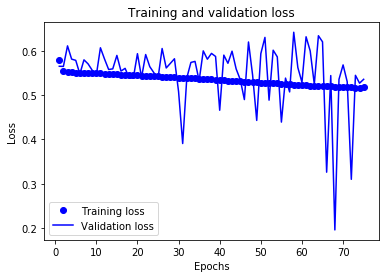

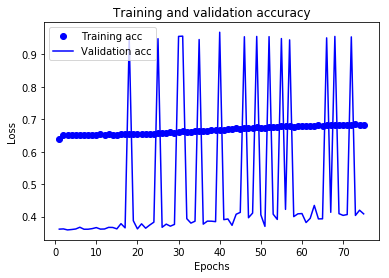


 *************** classifier.evaluate ******************* 

65228/65228 [==============================] - 3s 48us/step
[0.5102515637074124, 0.683418163980487]
7952/8347(95.27%) were correctly identified as bots
333765/556581 (59.97%) were wrongly identified as bots
======> PowerTransformer <==============
Train on 65228 samples, validate on 564928 samples
Epoch 1/75
65228/65228 [==============================] - 9s 136us/step - loss: 0.4703 - acc: 0.7995 - val_loss: 0.3543 - val_acc: 0.8728
Epoch 2/75
65228/65228 [==============================] - 9s 132us/step - loss: 0.3302 - acc: 0.8677 - val_loss: 0.3843 - val_acc: 0.8301
Epoch 3/75
65228/65228 [==============================] - 9s 133us/step - loss: 0.3020 - acc: 0.8754 - val_loss: 0.2893 - val_acc: 0.8951
Epoch 4/75
65228/65228 [==============================] - 9s 132us/step - loss: 0.2846 - acc: 0.8836 - val_loss: 0.2641 - val_acc: 0.9064
Epoch 5/75
65228/65228 [==============================] - 9s 132us/step - loss: 0.2718 - 

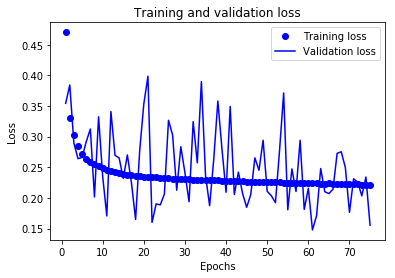

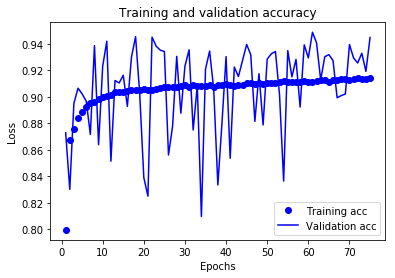


 *************** classifier.evaluate ******************* 

65228/65228 [==============================] - 3s 50us/step
[0.24412450984969278, 0.902311890595474]
7140/8347(85.54%) were correctly identified as bots
30023/556581 (5.39%) were wrongly identified as bots
======> QuantileTransformer <==============
Train on 65228 samples, validate on 564928 samples
Epoch 1/75
65228/65228 [==============================] - 9s 138us/step - loss: 0.4108 - acc: 0.8378 - val_loss: 0.3002 - val_acc: 0.8867
Epoch 2/75
65228/65228 [==============================] - 9s 133us/step - loss: 0.3159 - acc: 0.8635 - val_loss: 0.3610 - val_acc: 0.8538
Epoch 3/75
65228/65228 [==============================] - 9s 134us/step - loss: 0.3106 - acc: 0.8671 - val_loss: 0.3399 - val_acc: 0.8684
Epoch 4/75
65228/65228 [==============================] - 9s 133us/step - loss: 0.3091 - acc: 0.8677 - val_loss: 0.3371 - val_acc: 0.8674
Epoch 5/75
65228/65228 [==============================] - 9s 134us/step - loss: 0.3082 

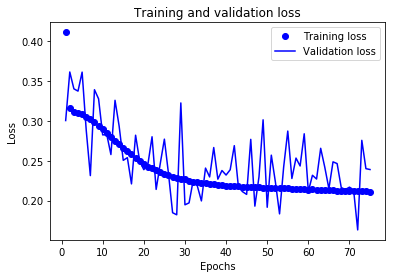

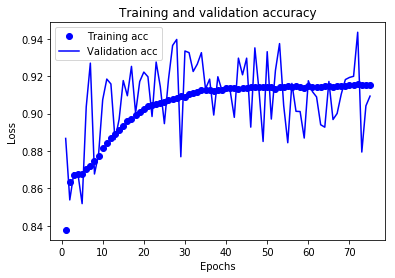


 *************** classifier.evaluate ******************* 

65228/65228 [==============================] - 3s 49us/step
[0.2075689002600118, 0.918470595453462]
7685/8347(92.07%) were correctly identified as bots
50574/556581 (9.09%) were wrongly identified as bots


In [12]:
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler
print("======> StandardScaler <==============")
scale_and_run(x_train.copy(), y_train.copy(), x_test.copy(), y_test.copy(),  StandardScaler())
print("======> PowerTransformer <==============")
scale_and_run(x_train.copy(), y_train.copy(), x_test.copy(), y_test.copy(),  PowerTransformer())
print("======> QuantileTransformer <==============")
scale_and_run(x_train.copy(), y_train.copy(), x_test.copy(), y_test.copy(),  QuantileTransformer())




In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0
